# 2021-01-16 Semi-complete affordance-based value functions

Results below are for commit: ### add
(Rerunning the code below for other commits is not guaranteed to give the same results)

There is now a semi-complete version of affordance-based value functions, considering both access order outcomes in terms of the accelerations needed to achieve them from the predicted states. The value of a state $\mathbf{x}(t)$ assuming own action $\mathbf{a}$ and other's behavior $\mathbf{b}$ is:

$$
V[\mathbf{x}(t), \mathbf{a}, \mathbf{b}] = \max_{\Omega} V[\mathbf{x}(t), \mathbf{a}, \mathbf{b}, \Omega]
$$

where $\Omega \in \{ \Omega_{1st}, \Omega_{2nd} \}$ is the access order, and:

$$
V[\mathbf{x}(t), \mathbf{a}, \mathbf{b}, \Omega] = \int_t^{\infty} g[ v_{\mathbf{x}(t), \mathbf{a}, \mathbf{b}, \Omega}(t'), a_{\mathbf{x}(t), \mathbf{a}, \mathbf{b}, \Omega}(t') ] \delta(t' - t) dt'
$$

where $v_{\mathbf{x}(t), \mathbf{a}, \mathbf{b}, \Omega}(t')$ and $a_{\mathbf{x}(t), \mathbf{a}, \mathbf{b}, \Omega}(t')$ are the future speeds and accelerations achieving $\Omega$ given  $\mathbf{x}(t)$, $\mathbf{a}$, and $\mathbf{b}$, $\delta(t)$ is a temporal discounting function:

$$
\delta(t) = 2^{-\frac{t}{T_{\delta}}} = e^{-\frac{\ln 2}{T_{\delta}}t}
$$

and $g[v, a]$ is a value rate (or reward/punishment rate) function:

$$
g[v, a] = k_g v - k_{dv} v^2 - k_{da} a^2.
$$

So in terms of the basic value function above this is similar to before, but now collisions are not directly considered in the value function, they rather get considered indirectly in terms of the speeds and accelerations $v_{\mathbf{x}(t), \mathbf{a}, \mathbf{b}, \Omega}(t')$ and $a_{\mathbf{x}(t), \mathbf{a}, \mathbf{b}, \Omega}(t')$ required to pass either before ($\Omega = \Omega_{1st}$) or after (($\Omega = \Omega_{2nd}$) the other agent. It is in this sense that the value function is now affordance-based, because it specifies the values of predicted states in terms of the subsequent actions (wrt the access orders) that these predicted states afford. They could become even more explicitly affordance-based by for example making the speed and acceleration penalties (the $k_dv$ and $k_da$ terms of $g[v, a]$) become infinite when physical limits are hit. 

In the current implementation the value integral proposed above is simplified as noted in my physical notebook notes dated 2020-12-22 (to be described elsewhere).

I have also normalised the value functions across the two agent types, as explained in the scanned handwritten notes dated 2021-01-16.


## Some current limitations to work on (adding todonotes for these)

* The estimation of future acceleration to regain free speed in `sc_scenario_helper.get_access_order_implications()` is currently hardcoded to "acceleration needed to reach free speed in 10 s" (the calculation previously used there was sort of ok for v0.1, but probably rather incorrect for v0.2 - and I was seeing weird results from using it).
* I have added a simple placeholder $\pm$100 saturation for value $V$ of an action - pending proper squashing of the value function as experimented with elsewhere.
* If both agents start from standstill, they currently don't get going at all...?!
* I have not yet added calculation of delays for waiting time and regaining speed - these are made use of in `SCAgent.get_access_order_values_for_agent_v02()` but are currently just set to zero in `sc_scenario_helper.get_access_order_implications()`.
* The action values become -inf on and off when different access orders are deemed impossible by the current implementation. In principle this is as intended, but the way it looks currently doesn't seem completely right.
* When yielding to (near-)standstill just at the edge of the pedestrian's crossing area, the car sometimes continues sliding into it and just keeps going (see further below for an example). I think the problem here lies in how collisions are treated; basically once the collision is a fact the value function does not care whether the car continues going. One idea might be to allow some sort of tolerance for small incursions into the pedestrian crossing area at very low speeds?
* Strange estimated behaviour probabilities, whereby both speed(/acceleration) increases and decreases can cause an estimate that the other agent will pass first to change into an estimate that the other agent will pass second. See below for example.


## Init

In [1]:
# put root folder of repo PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))
print(sys.path[-1])

C:\GITHUB\COMMOTIONSFramework


In [2]:
# imports needed to run the simulations
import numpy as np
import commotions
import sc_scenario
from sc_scenario import get_assumptions_dict, SCSimulation
from sc_scenario_helper import CtrlType

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:88: UserWarning: N_ACTIONS set to no of actions in default params, so will not work if non-default params are set.
  warnings.warn('N_ACTIONS set to no of actions in default params, so will not work if non-default params are set.')


## Just the base model - no interaction

First just running the base model with v0.2 value functions to show that with default parameters the accelerations to free flow speed from standstill look reasonable - but it doesn't now for some reason; nothing happens! Previously when I was working on these updates this worked, and the acceleration profiles looked sensible - but this needs looking at now.

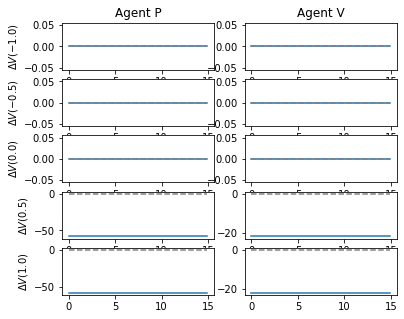

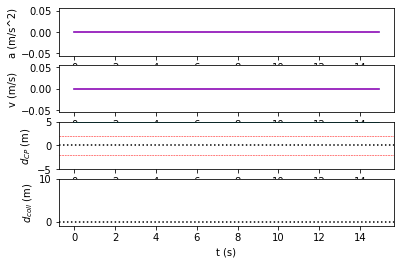

In [5]:
CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) 
INITIAL_POSITIONS = np.array([[0,-5], [400, 0]])
GOALS = np.array([[0, 5], [-50, 0]])
SPEEDS = np.array((0, 0))

optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = False, oBEvs = False, oEA = False)  
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(kinem_states = True, surplus_action_vals = True)

## Just the base model - same interaction scenario as in recent diary entries

In previous diary notebook simulations (i.e. with the v0.1 value functions) with this kinematical scenario, the pedestrian just adapts speed to pass behind the vehicle, but with the v0.2 value functions the pedestrian is more aggressive, which in turn prompts a speed increase from the car:

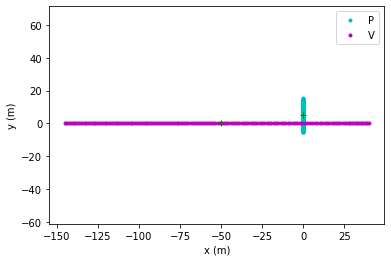

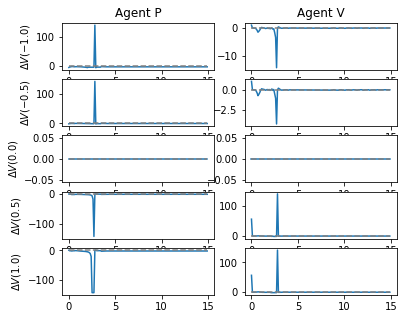

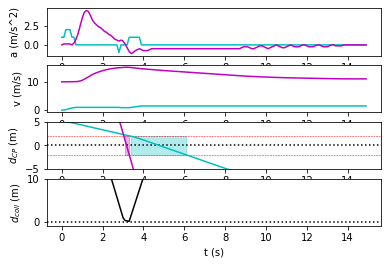

In [6]:
INITIAL_POSITIONS = np.array([[0,-5], [40, 0]])
SPEEDS = np.array((0, 10))

optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = False, oBEvs = False, oEA = False)  
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(
        trajs = True, kinem_states = True, surplus_action_vals = True)

The kinematics-dependence is still there though - for smaller initial vehicle TTAs the pedestrian does not attempt to pass in front, and for larger TTAs the vehicle lets the pedestrian pass first:

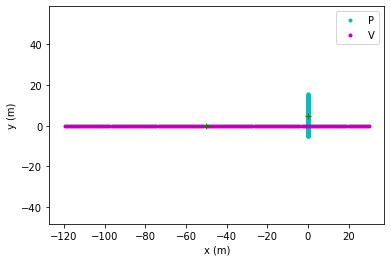

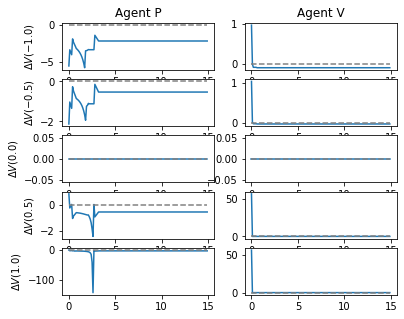

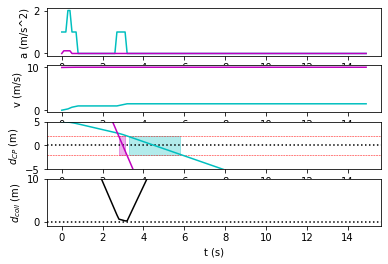

In [6]:
INITIAL_POSITIONS = np.array([[0,-5], [30, 0]])

sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(
        trajs = True, kinem_states = True, surplus_action_vals = True)

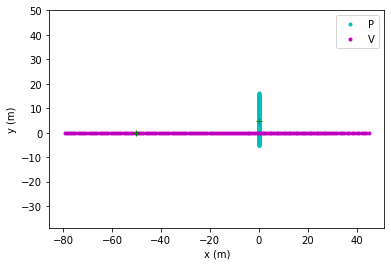

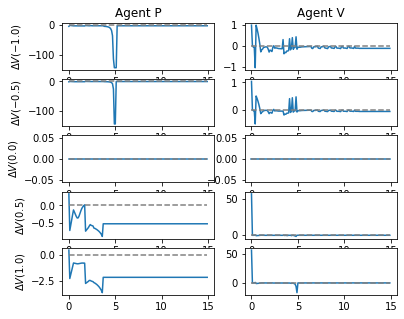

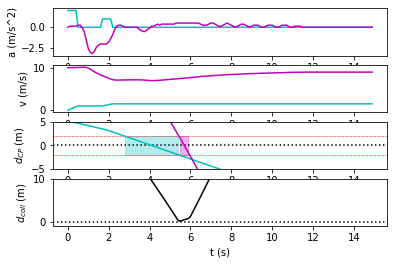

In [7]:
INITIAL_POSITIONS = np.array([[0,-5], [45, 0]])

sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(
        trajs = True, kinem_states = True, surplus_action_vals = True)

## Adding a cost function term penalising non-compliance with priority rules

Something which has not been straightforward to add to the v0.1 value functions, but which comes naturally now, is a cost function term penalising the car for passing before the pedestrian - to emulate priority rules at a pedestrian crossing. Returning to the first kinematical scenario above (the one where the pedestrian increased speed, and the car responded with the same to pass first), we can now get the car to yield:

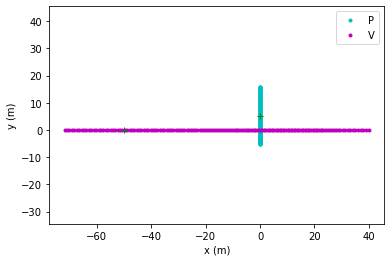

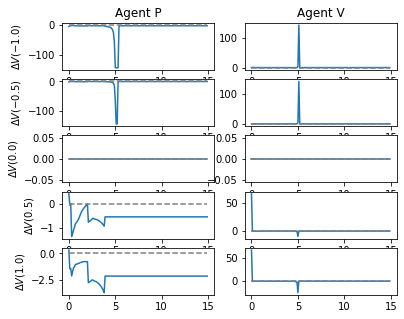

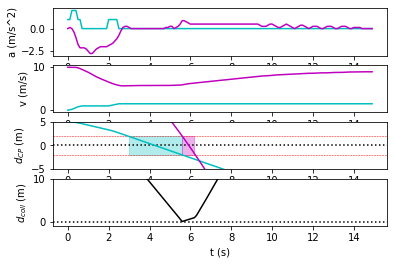

In [17]:
INITIAL_POSITIONS = np.array([[0,-5], [40, 0]])

(params, params_k) = sc_scenario.get_default_params()
params.V_ny = -15
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'), params = params)
sc_simulation.run()
sc_simulation.do_plots(
        trajs = True, kinem_states = True, surplus_action_vals = True)

Reducing the initial vehicle TTA we can get complete or near-complete yielding - i.e., the pedestrian is not comfortable crossing before this point. There is however a slight problem sometimes with only-near-complete yielding, where the vehicle slides into the pedestrian's crossing area, thus preventing the pedestrian from passing first:

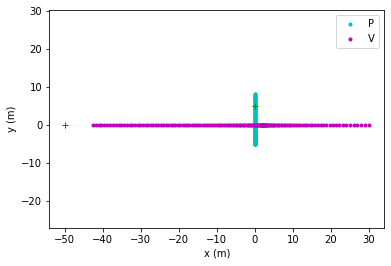

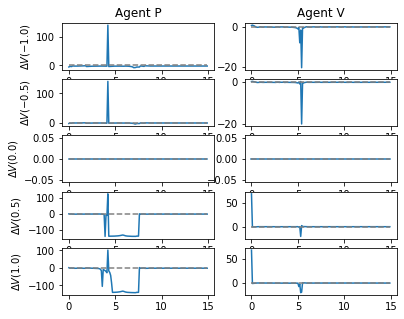

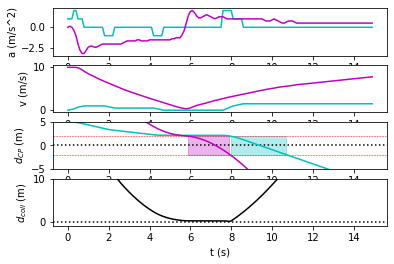

In [18]:
INITIAL_POSITIONS = np.array([[0,-5], [30, 0]])

sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'), params = params)
sc_simulation.run()
sc_simulation.do_plots(
        trajs = True, kinem_states = True, surplus_action_vals = True)

Reducing the initial vehicle TTA even further the vehicle can skip the yielding however - which is nice. (Of course this all depends on the exact value of the $V_{ny}$ parameter.):

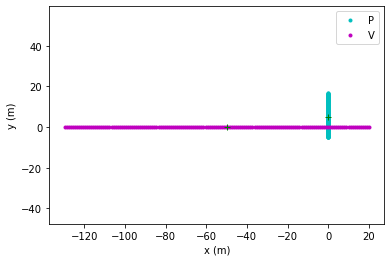

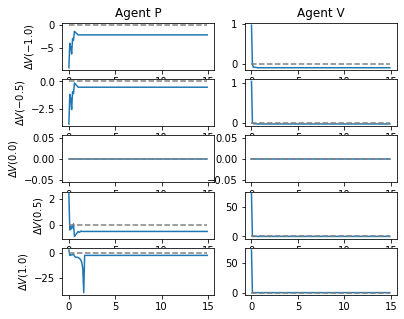

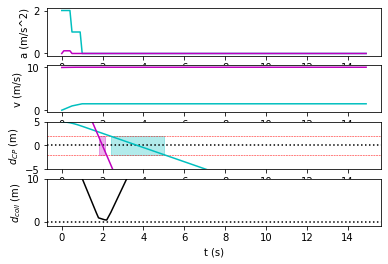

In [19]:
INITIAL_POSITIONS = np.array([[0,-5], [20, 0]])

sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'), params = params)
sc_simulation.run()
sc_simulation.do_plots(
        trajs = True, kinem_states = True, surplus_action_vals = True)

## `oBEvs`

Reverting back to the baseline kinematical scenario and removing the penalty for non-yielding - and enabling `oBEvs`. The behaviour is very similar to the simulation above without `oBEvs`, but the behaviour probabilities estimated by the pedestrian in the t = 1-3 s seem a little strange: The pedestrian judges that if keeping own current speed, the car will pass first (sensible), if increasing own speed the car will instead probably rather pass second (plausible), but if decreasing own speed the will also rather pass second; this latter estimate seems puzzling and should be looked into.

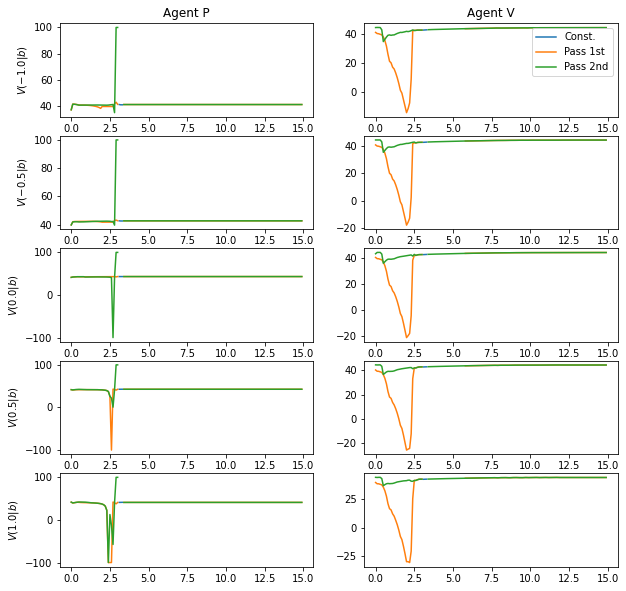

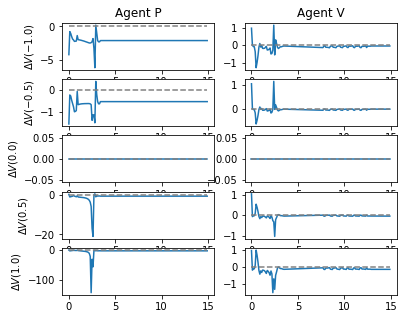

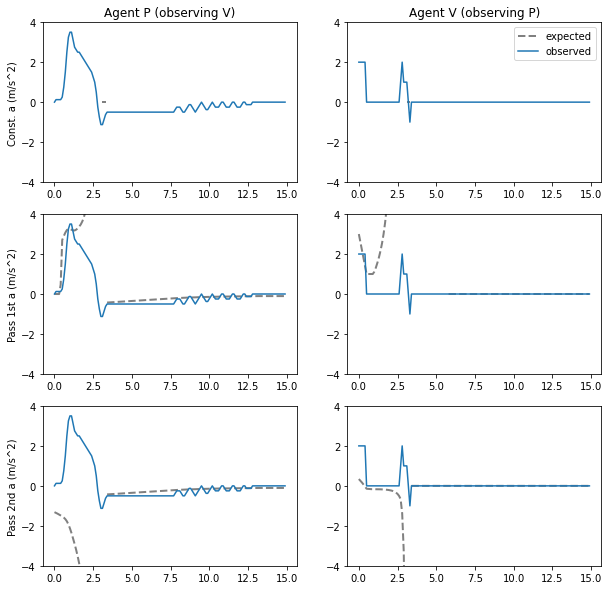

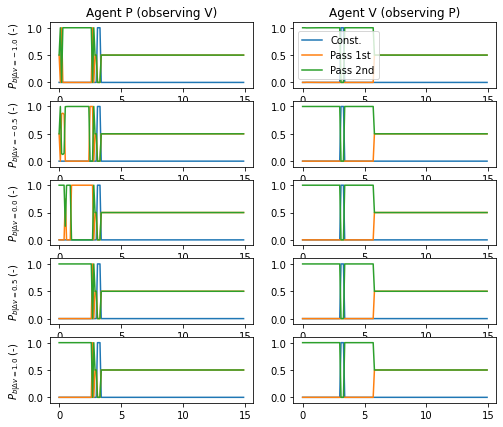

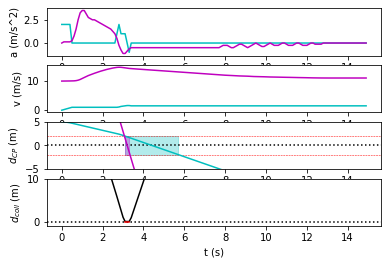

In [20]:
INITIAL_POSITIONS = np.array([[0,-5], [40, 0]])

(params, params_k) = sc_scenario.get_default_params()
optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = False, oBEvs = True, oEA = False)  
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        params = params, agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(
        kinem_states = True, beh_probs = True, beh_accs = True, surplus_action_vals = True, action_vals = True)

Not doing any further tests here with `oBEao` or `oEA` - there is enough to work on from the above already...